In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('DataClear.csv')

# 将各个词汇的使用频数转换为0-1，0表示未出现某个词汇，而1表示出现了某个词汇
data.iloc[:, 1:] = np.where(data.iloc[:, 1:]>=1, 1, 0)

institution_name = data['单位名称'].unique()  #提取不同单位名称
index=range(len(institution_name))

data['单位名称'].replace(institution_name,index,inplace=True)#  替换单位名称为数字

X = data.iloc[:, 1:].values
y = data['单位名称'].values

朴素贝叶斯

测试准确率 is 0.9394
混淆矩阵


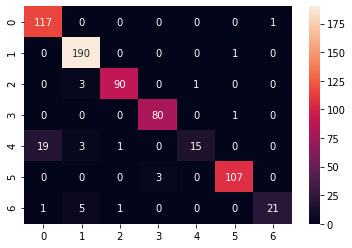

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

pred_test=clf.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix
print("测试准确率 is %.4f" %accuracy_score(y_test,pred_test))
print("混淆矩阵")
cm=confusion_matrix(y_test,pred_test)
import seaborn as sns
ax = sns.heatmap(cm, annot=True, fmt="d")

利用sklearn.discriminant_analysis.LinearDiscriminantAnalysis来拟合生成的两个高斯分布，来验证所推导的公式

In [4]:
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 生成的数据为 (0, 0)为中心，协方差矩阵为单位阵的高斯分布
# 和(2,2)为中心，协方差为单位阵的高斯分布
cluster_1 = np.random.multivariate_normal([0, 0], np.diag([1, 1]), 500)
cluster_2 = np.random.multivariate_normal([2, 2], np.diag([1, 1]), 500)

label = np.asarray([0]*len(cluster_1) + [1]*len(cluster_2))
LDA_data = np.row_stack([cluster_1, cluster_2])
shuffle_index = np.arange(len(LDA_data))
random.shuffle(shuffle_index)

LDA_data = LDA_data[shuffle_index]
label = label[shuffle_index]

In [5]:
LDA = LinearDiscriminantAnalysis()
result = LDA.fit(LDA_data, label)

In [6]:
pred=LDA.predict(LDA_data)
print("准确率为")
accuracy_score(label,pred)

准确率为


0.905

In [7]:
print(result.coef_)  # 权重向量

[[1.94827073 1.95105865]]


In [8]:
print(result.intercept_)

[-3.9263607]


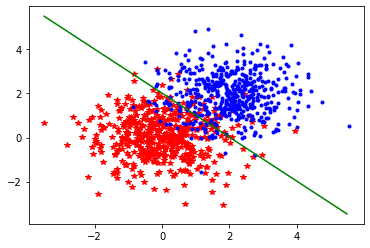

In [9]:
figure = plt.figure(1)

plt.plot(LDA_data[label==0][:, 0], LDA_data[label==0][:, 1], 'r*')
plt.plot(LDA_data[label==1][:, 0], LDA_data[label==1][:, 1], 'b.')



def f(x):
    y=-x*result.coef_[0][0]/result.coef_[0][1]-result.intercept_[0]/result.coef_[0][1]
    return y
x_axis = np.arange(-3.5, 5.5, 0.01)
y=f(x_axis)
plt.plot(x_axis, y, 'g-')#判别曲线
plt.show()

自己编写程序实现LDA

In [10]:
from numpy.linalg import inv
class LDA_model:

    def __init__(self, n_components= 2):#默认2分类，可以调节参数进行多分类

        self.n_components = n_components

        self.means_ = None

        self.covariances_ = None

        self.weights_=None
     
         
    def fit(self, X_train,y_train):#y_train输入 应该是数字   在0 到 self.n_compunets-1之间

        # 获取一些必要的数据信息

        n_samples, n_feature = X_train.shape

      

        # 均值，协方差, 权重

        self.means_ = np.zeros((self.n_components, n_feature))
        for i in range(self.n_components):
            self.means_[i]=np.mean(X_train[y_train==i],axis=0)
        self.covariances_ =np.zeros((n_feature,n_feature))
        #print(self.covariances_ .shape)
        N=[]
        for i in range(self.n_components):
            N.append(X_train[y_train==i].shape[0])
            #print(np.cov(X_train[y_train==i]).shape)
            self.covariances_ += N[i]*(np.cov(X_train[y_train==i].T))
        self.covariances_ =self.covariances_/(sum(N)-self.n_components)
        
        self.weights_ = np.ones(self.n_components) / self.n_components


        for k in range(self.n_components):
            self.weights_[k] = N[k] / n_samples
  

    def predict(self, X_test):
        n_samples=X_test.shape[0]
        #### E-step，计算概率 ####
        delta=np.zeros((n_samples,self.n_components))
        #print(np.matmul(np.matmul(X_test,inv(self.covariances_)),self.means_[0]).shape)
        for i in range(self.n_components):
            delta[:,i]=np.matmul(np.matmul(X_test,inv(self.covariances_)),self.means_[i])-0.5*np.matmul(self.means_[i].reshape(1,-1),inv(self.covariances_)).dot(self.means_[i])+np.log(self.weights_[i])
        pred=np.argmax(delta,1)
        return pred
        


In [11]:
lda=LDA_model()
lda.fit(LDA_data, label)

In [12]:
pred1=lda.predict(LDA_data)
print("自写LDA准确率为")
accuracy_score(label,pred1)

自写LDA准确率为


0.905

In [13]:
coef_0=-0.5*np.matmul(lda.means_[0].reshape(1,-1),inv(lda.covariances_)).dot(lda.means_[0])+np.log(lda.weights_[0])+0.5*np.matmul(lda.means_[1].reshape(1,-1),inv(lda.covariances_)).dot(lda.means_[1])-np.log(lda.weights_[1])

In [14]:
coef_0#interpret

array([3.91850798])

In [15]:
coef_1=np.matmul(inv(lda.covariances_),lda.means_[0]-lda.means_[1])#权重向量

In [16]:
coef_1

array([-1.94437419, -1.94715654])

In [17]:
print("和sklearn.discriminant_analysis.LinearDiscriminantAnalysis预测结果的匹配程度为")
print(accuracy_score(pred,pred1)*100,"%")

和sklearn.discriminant_analysis.LinearDiscriminantAnalysis预测结果的匹配程度为
100.0 %


对于训练集的预测和python里的LDA完全一样

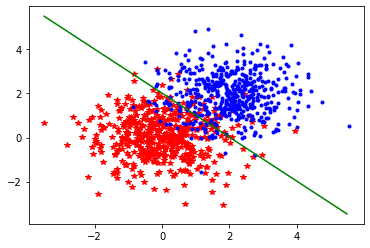

In [18]:
figure = plt.figure(2)

plt.plot(LDA_data[label==0][:, 0], LDA_data[label==0][:, 1], 'r*')
plt.plot(LDA_data[label==1][:, 0], LDA_data[label==1][:, 1], 'b.')


def f(x):
    y=-x*coef_1[0]/coef_1[1]-coef_0/coef_1[1]
    return y
x_axis = np.arange(-3.5, 5.5, 0.01)
y=f(x_axis)
plt.plot(x_axis, y, 'g-')#判别曲线
plt.show()